In [6]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from time import time

# plotting utilities
import revert.plot as rp

# infusion data loaders
from revert import infusion

d = torch.load("../scripts-infusion/baseline.pt")

### Read ICP recording and timestamps

In [60]:
from revert.transforms import filter_spikes, bandpass, Troughs

key = d["keys"][66]
#key = 'inf_20140721123111_INF2'

db = infusion.Dataset("full")
fs = 100
file = db.get(key)

# read full icp recording
icp_raw = file.icp()

# interpolate on missing data points
icp_full, mask = filter_spikes(icp_raw)

# read timestamps from $INFUSION_DATASETS/periods-full.json
periods = db.periods[file.key]

INF_20120418103251_INF1: 1 block(s)


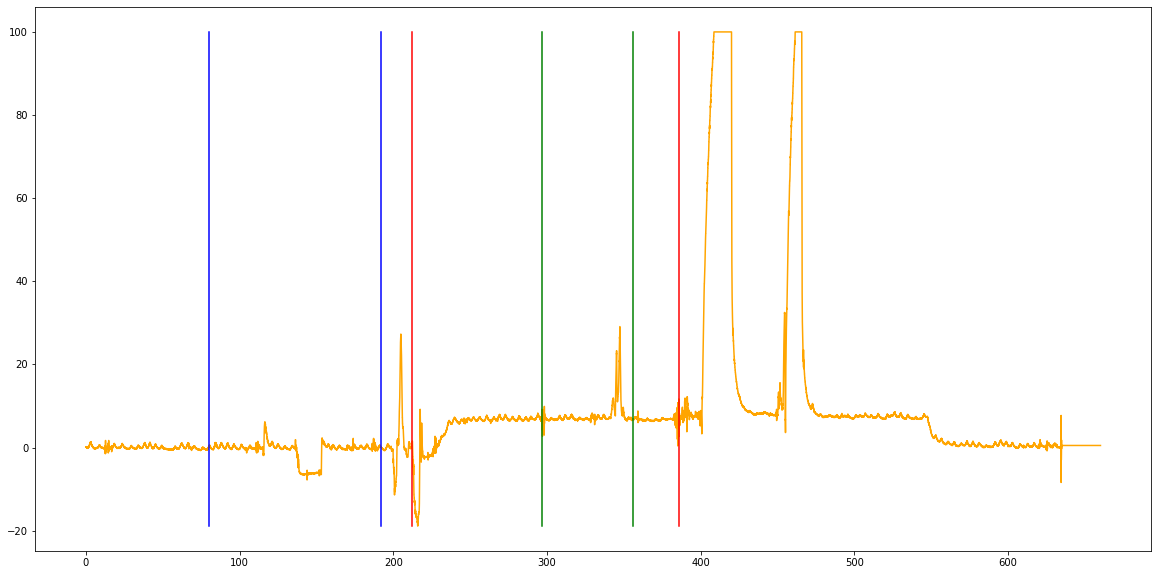

In [67]:
# plot with timestamps
rp.infusion(icp_full, periods)
print(f'{file.key}: {file.nblocks()} block(s)')

In [68]:
torch.min(icp_full)

tensor(-18.8995)

In [69]:
file['waves/icp.index'][:]
dict(file.attrs)

{'dataCollectionSoftware': array(['ICM+ 7.2'], dtype=object),
 'dataEndTime': array(['2012/04/18 11:22:09'], dtype=object),
 'dataEndTimeUnix': array(['1334748129'], dtype=object),
 'dataProcessingSoftware': array(['ICM+ 9.1.5.3'], dtype=object),
 'dataStartTime': array(['2012/04/18 11:11:08'], dtype=object),
 'dataStartTimeUnix': array(['1334747468'], dtype=object),
 'dateTimeFormat': array(['yyyy/mm/dd hh:nn:ss'], dtype=object),
 'duration': array(['661 seconds'], dtype=object),
 'formatVersion': array(['1.3'], dtype=object),
 'invalidValue': array(['-99999'], dtype=object),
 'protocol': array([''], dtype=object)}

In [70]:
file['waves/icp']

<HDF5 dataset "icp": shape (66029,), type "<f4">

### Segment baseline signal

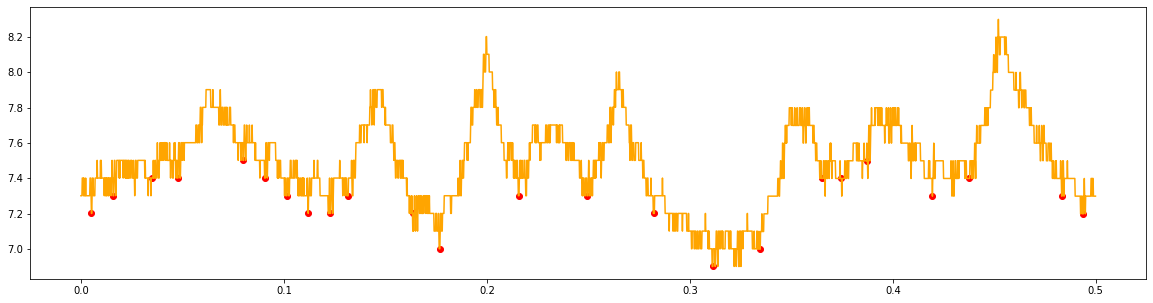

In [71]:
# Baseline first minutes
i0     = periods["start"]
i1, i2 = periods["Baseline"]
i1 += 400
N = 1 * 3000
time = torch.arange(N) / (fs * 60)
icp  = icp_full[int(100 * (i1 - i0)):int(100 * (i1 - i0)) + N]

# Find diastoles
argmin  = Troughs(N, 50)
bp      = bandpass(0.7, 16, fs)
troughs = argmin(bp(icp))

# Plot 
plt.figure(figsize=(20, 5))
plt.plot(time, icp, color='orange')
plt.scatter(time[troughs], icp[troughs], color='red')
plt.show()

In [91]:
y1 = torch.unique(icp)

y= torch.diff(torch.sort(y1).values).abs()

y2 = torch.diff(icp).abs()
y2[y2.nonzero().flatten()].min() >= .099

tensor(True)

### Model image of the segments


In [72]:
from revert.models     import ConvNet
from revert.transforms import segment, mask_center, diff

# model trained on synthetic augmentations only
# (noise, scalings, dc shifts) - see revert/experiments/twins.py
model = ConvNet.load("pretrained.pt")

# centered segments
pulses, mask = segment(bp(icp), troughs, 128, before=0)
x, x_mean, x_slope = mask_center(pulses, mask, output='slopes')

# model output
with torch.no_grad():
    y  = model(x).detach()

In [73]:
# model variation
dy = diff(y.T).T
y_m = y - y.mean([0])[None,:]

# energy
q1, q2 = y_m.norm(dim=[1]), dy.norm(dim=[1])
q = q1 + q2

# temperature
T = 1.5

# Gibbs density (~ softmin)
p = torch.exp(- q / T)
p /= p.sum()

p_norm = (p - p.min()) / (p.max() - p.min())


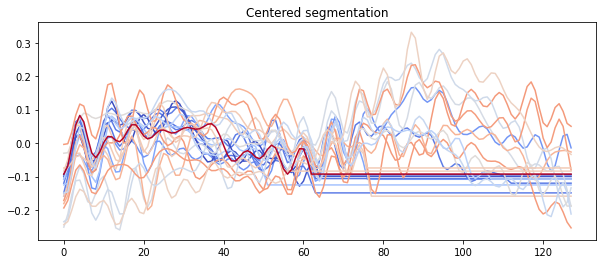

In [74]:
color=cm.coolwarm_r(p_norm)

plt.figure(figsize=(10, 4))
for xi, ci in zip(x, color):
    plt.plot(xi, color=ci)
plt.title("Centered segmentation")
plt.show()

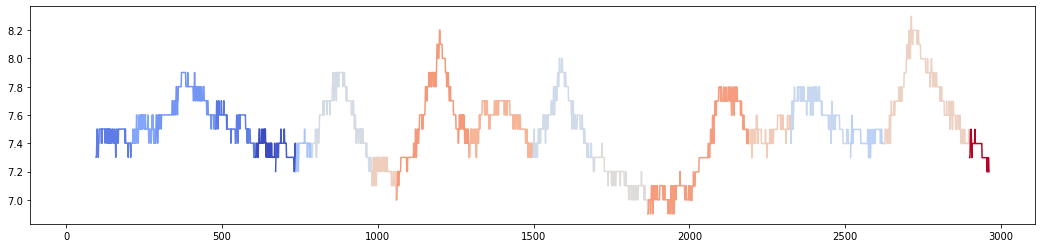

In [75]:
plt.figure(figsize=(18, 4))
for i, j, cij in zip(troughs[:-1], troughs[1:], color):
    ij = i + torch.arange(j - i)
    pij = icp[i:j]
    plt.plot(ij, pij, color=cij)

### Pulse selection

Text(0.5, 1.0, 'Max probability pulses')

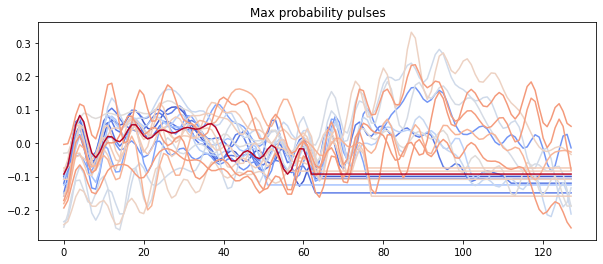

In [18]:
idx = p.sort(descending=True).indices[:32]

rp.pulses(x[idx], c=p_norm[idx])
plt.title("Max probability pulses")

---
## Segmentation results

Read from results of `revert/scripts-infusion/extract_pulses.py`

In [19]:
d = torch.load("../scripts-infusion/baseline.pt")
pulses = d['pulses']
masks  = d['masks']

from revert.transforms import unshift

def plot_pulses(i):
    N = 64
    xi = pulses[i][:N]
    #xi = unshift(xi, masks[i][:N])
    rp.pulses(xi, c=1 - torch.linspace(0, .5, N))
    rp.plt.title(f"{d['keys'][0]}")

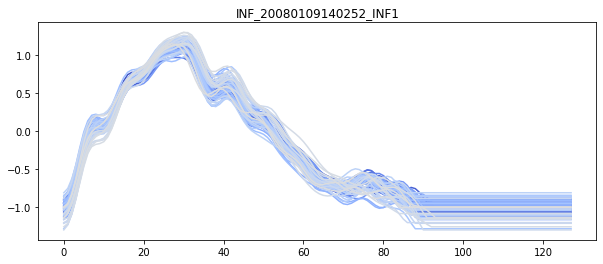

In [20]:
plot_pulses(3)

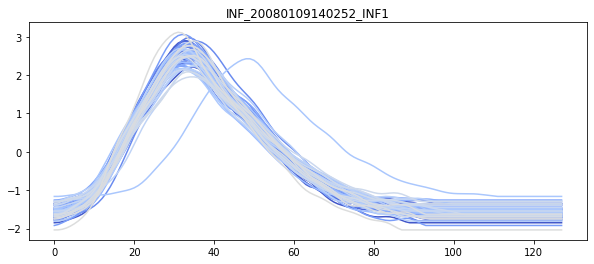

In [21]:
plot_pulses(12)

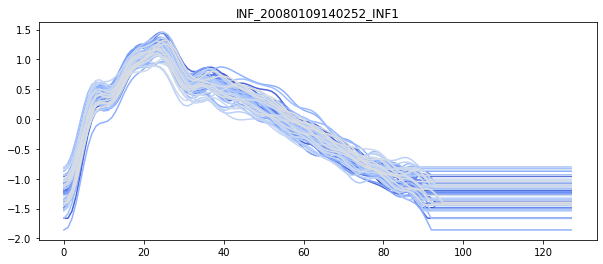

In [22]:
plot_pulses(1222)

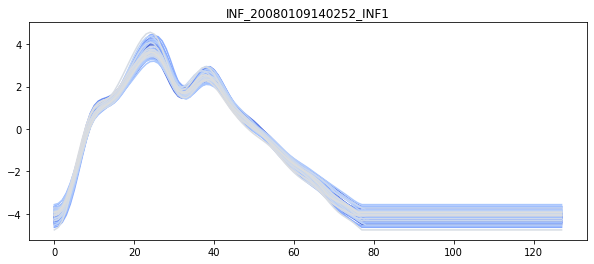

In [23]:
plot_pulses(42)

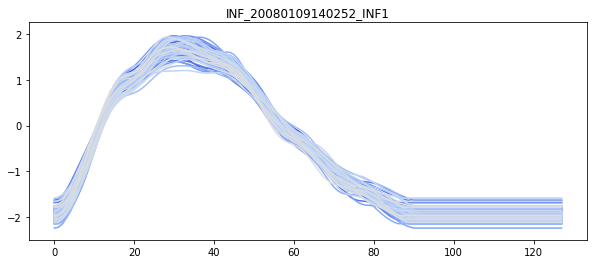

In [24]:
plot_pulses(69)

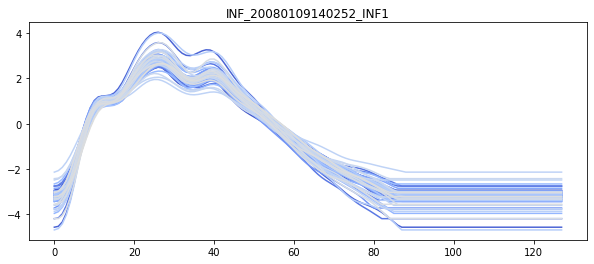

In [25]:
plot_pulses(172)

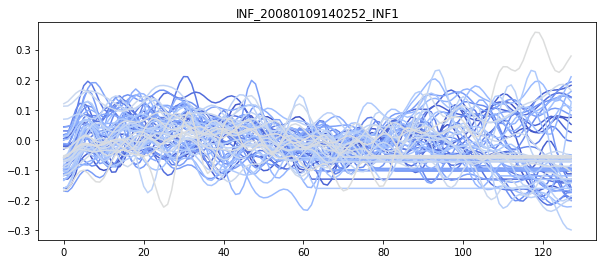

In [26]:
plot_pulses(66)

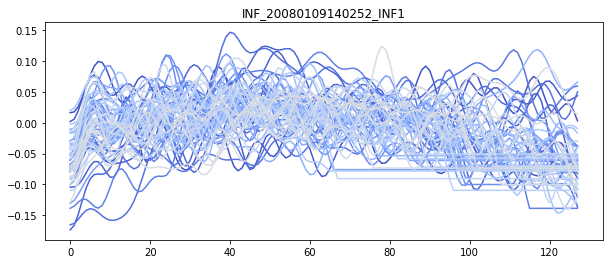

In [27]:
plot_pulses(32)

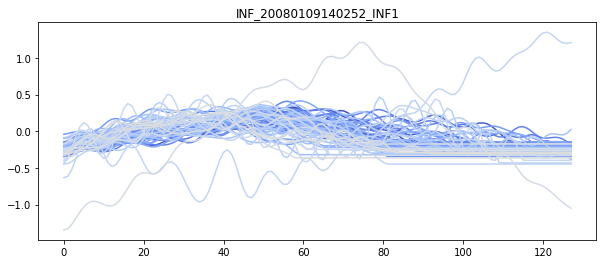

In [28]:
plot_pulses(148)